In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

Total number of categories: 150
Total number of images in dataset: 10842


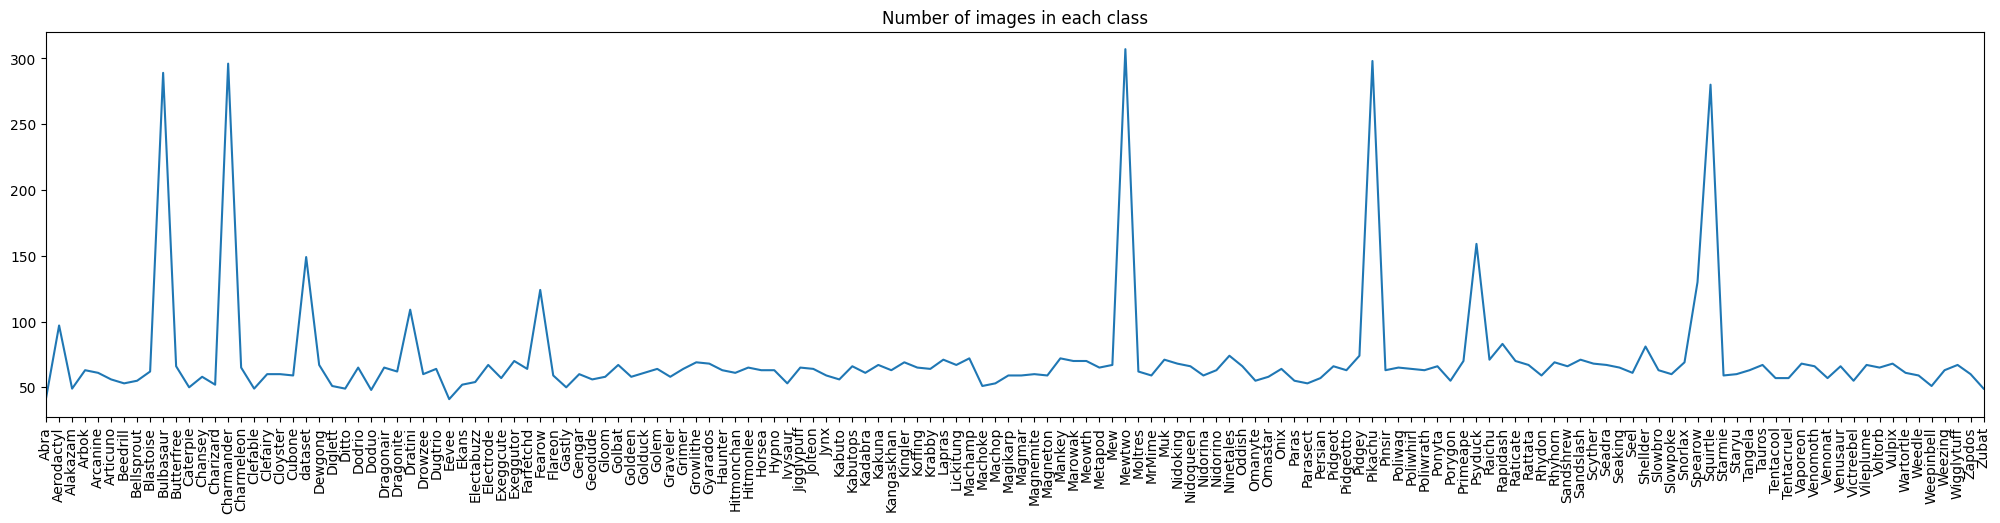

In [2]:
# A little bit of data exploration
path = './dataset' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [3]:


# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)



[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [4]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')


./dataset\Mewtwo\ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


In [5]:
from collections import Counter

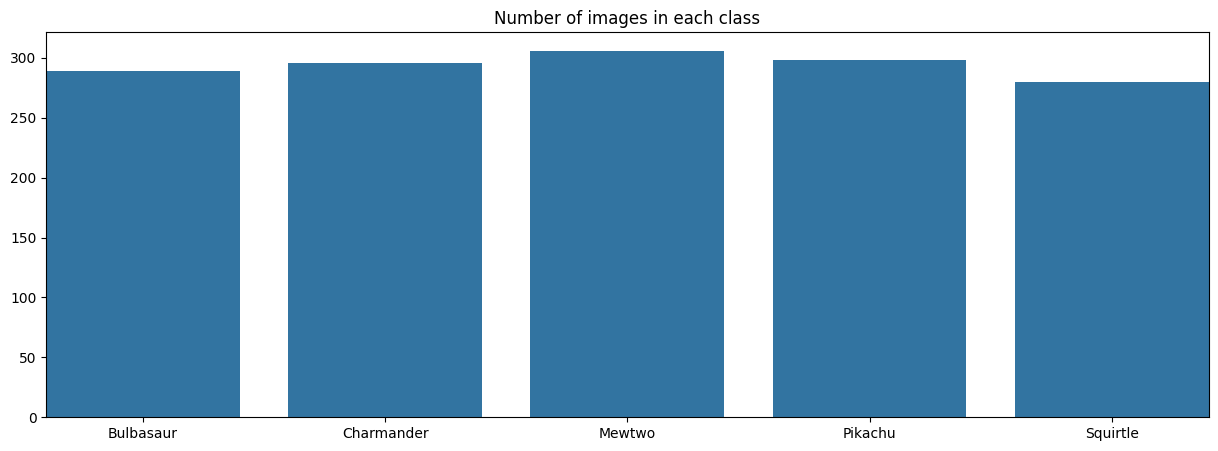

In [6]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader

In [8]:

# Supongamos que X es una lista de imágenes y su tamaño debe ser (N, 96, 96, 3)
X = np.array(X).reshape(-1, 96, 96, 3)  # Esto es equivalente en NumPy
X = torch.tensor(X, dtype=torch.float32)  # Convertir a tensor de PyTorch
X = X.permute(0, 3, 1, 2)  # Cambia el orden a (N, C, H, W)

X = X / 255.0  # Escala los valores al rango [0, 1]



# Convertir etiquetas (Y) a formato categórico
num_classes = len(imbalanced)
y = torch.tensor(Y, dtype=torch.long)  # Etiquetas originales como tensores
y = F.one_hot(y, num_classes=num_classes)  # One-hot encoding

# Crear un conjunto de datos a partir de tensores
dataset = TensorDataset(X, y)

# Dividir el conjunto de datos
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32  # Tamaño del lote

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # Bloque 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')  # input_shape=(96,96,3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.25)
        
        # Bloque 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.25)
        
        # Bloque 3
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.25)
        
        # Bloque 4
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop4 = nn.Dropout(0.25)
        
        # Capa totalmente conectada
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Ajusta el tamaño en función de la entrada
        self.bn8 = nn.BatchNorm1d(512)
        self.drop5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn9 = nn.BatchNorm1d(256)
        self.drop6 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = self.drop3(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool4(x)
        x = self.drop4(x)
        
        x = x.view(x.size(0), -1)  # Aplanar
        x = F.relu(self.bn8(self.fc1(x)))
        x = self.drop5(x)
        x = F.relu(self.bn9(self.fc2(x)))
        x = self.drop6(x)
        x = F.softmax(self.fc3(x), dim=1)  # Activación softmax
        return x

# Crear modelo
num_classes = len(imbalanced)
model = CNNModel(num_classes)

In [10]:
import os

# Ruta para guardar el mejor modelo
checkpoint_path = './working/best_model.pth'

# Función para guardar el modelo
def save_checkpoint(model, optimizer, epoch, accuracy, path=checkpoint_path):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'accuracy': accuracy
    }
    torch.save(state, path)



In [11]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Pérdida categórica
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Inicializar listas para almacenar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Adelante
        optimizer.zero_grad()
        outputs = model(images)

        # Calcular pérdida
        loss = criterion(outputs, torch.argmax(labels, dim=1))  # Etiquetas no deben ser one-hot
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == torch.argmax(labels, dim=1)).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    print(f"Epoch {epoch+1}/{100}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")

    # Validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, torch.argmax(labels, dim=1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == torch.argmax(labels, dim=1)).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(correct_val / total_val)

    print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    # Guardar el mejor modelo
    if val_accuracies[-1] > best_accuracy:
        print(f"New best accuracy: {val_accuracies[-1]:.4f}, saving model...")
        best_accuracy = val_accuracies[-1]
        save_checkpoint(model, optimizer, epoch, val_accuracies[-1])


Epoch 1/100, Train Loss: 0.9414, Train Accuracy: 0.9617
Validation Loss: 0.9557, Validation Accuracy: 0.9456
New best accuracy: 0.9456, saving model...
Epoch 2/100, Train Loss: 0.9322, Train Accuracy: 0.9719
Validation Loss: 0.9650, Validation Accuracy: 0.9320
Epoch 3/100, Train Loss: 0.9346, Train Accuracy: 0.9711
Validation Loss: 0.9787, Validation Accuracy: 0.9218
Epoch 4/100, Train Loss: 0.9379, Train Accuracy: 0.9677
Validation Loss: 0.9751, Validation Accuracy: 0.9218
Epoch 5/100, Train Loss: 0.9281, Train Accuracy: 0.9779
Validation Loss: 0.9666, Validation Accuracy: 0.9354
Epoch 6/100, Train Loss: 0.9334, Train Accuracy: 0.9736
Validation Loss: 0.9754, Validation Accuracy: 0.9184
Epoch 7/100, Train Loss: 0.9276, Train Accuracy: 0.9779
Validation Loss: 0.9694, Validation Accuracy: 0.9286
Epoch 8/100, Train Loss: 0.9276, Train Accuracy: 0.9762
Validation Loss: 0.9645, Validation Accuracy: 0.9354
Epoch 9/100, Train Loss: 0.9295, Train Accuracy: 0.9762
Validation Loss: 0.9703, Vali

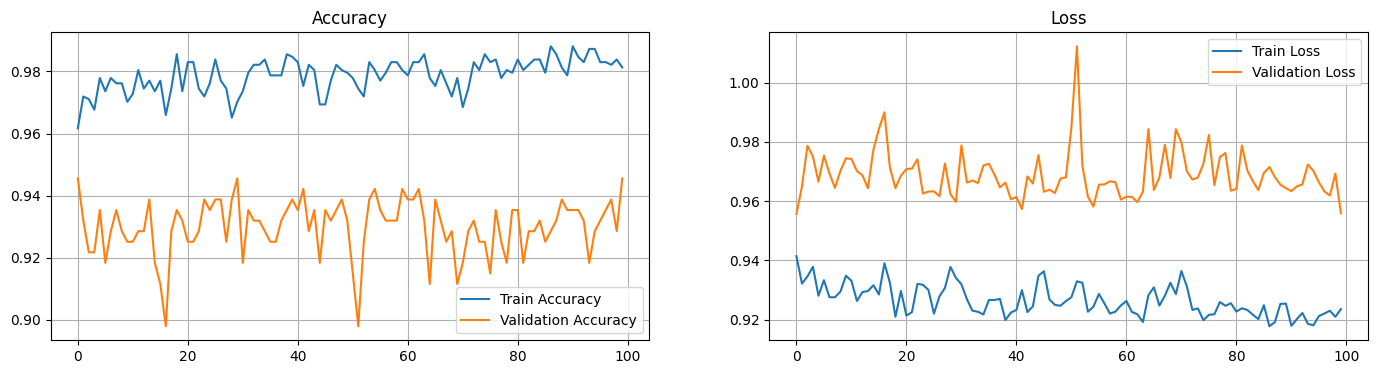

In [15]:
import matplotlib.pyplot as plt

# Crear la figura
fig = plt.figure(figsize=(17, 4))

# Gráfica de precisión
plt.subplot(121)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

# Gráfica de pérdida
plt.subplot(122)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()


In [22]:
# Cargar los pesos guardados
checkpoint_path = './working/best_model.pth'

# Cargar el modelo desde el checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])  # Cargar los pesos
model.eval()  # Poner el modelo en modo de evaluación
print("Pesos cargados desde el mejor modelo.")


Pesos cargados desde el mejor modelo.


C:\Users\Enriquetracker\AppData\Local\Temp\ipykernel_7096\3181653042.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


C:\Users\Enriquetracker\AppData\Local\Temp\ipykernel_7096\3799185914.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Pesos cargados desde el mejor modelo.


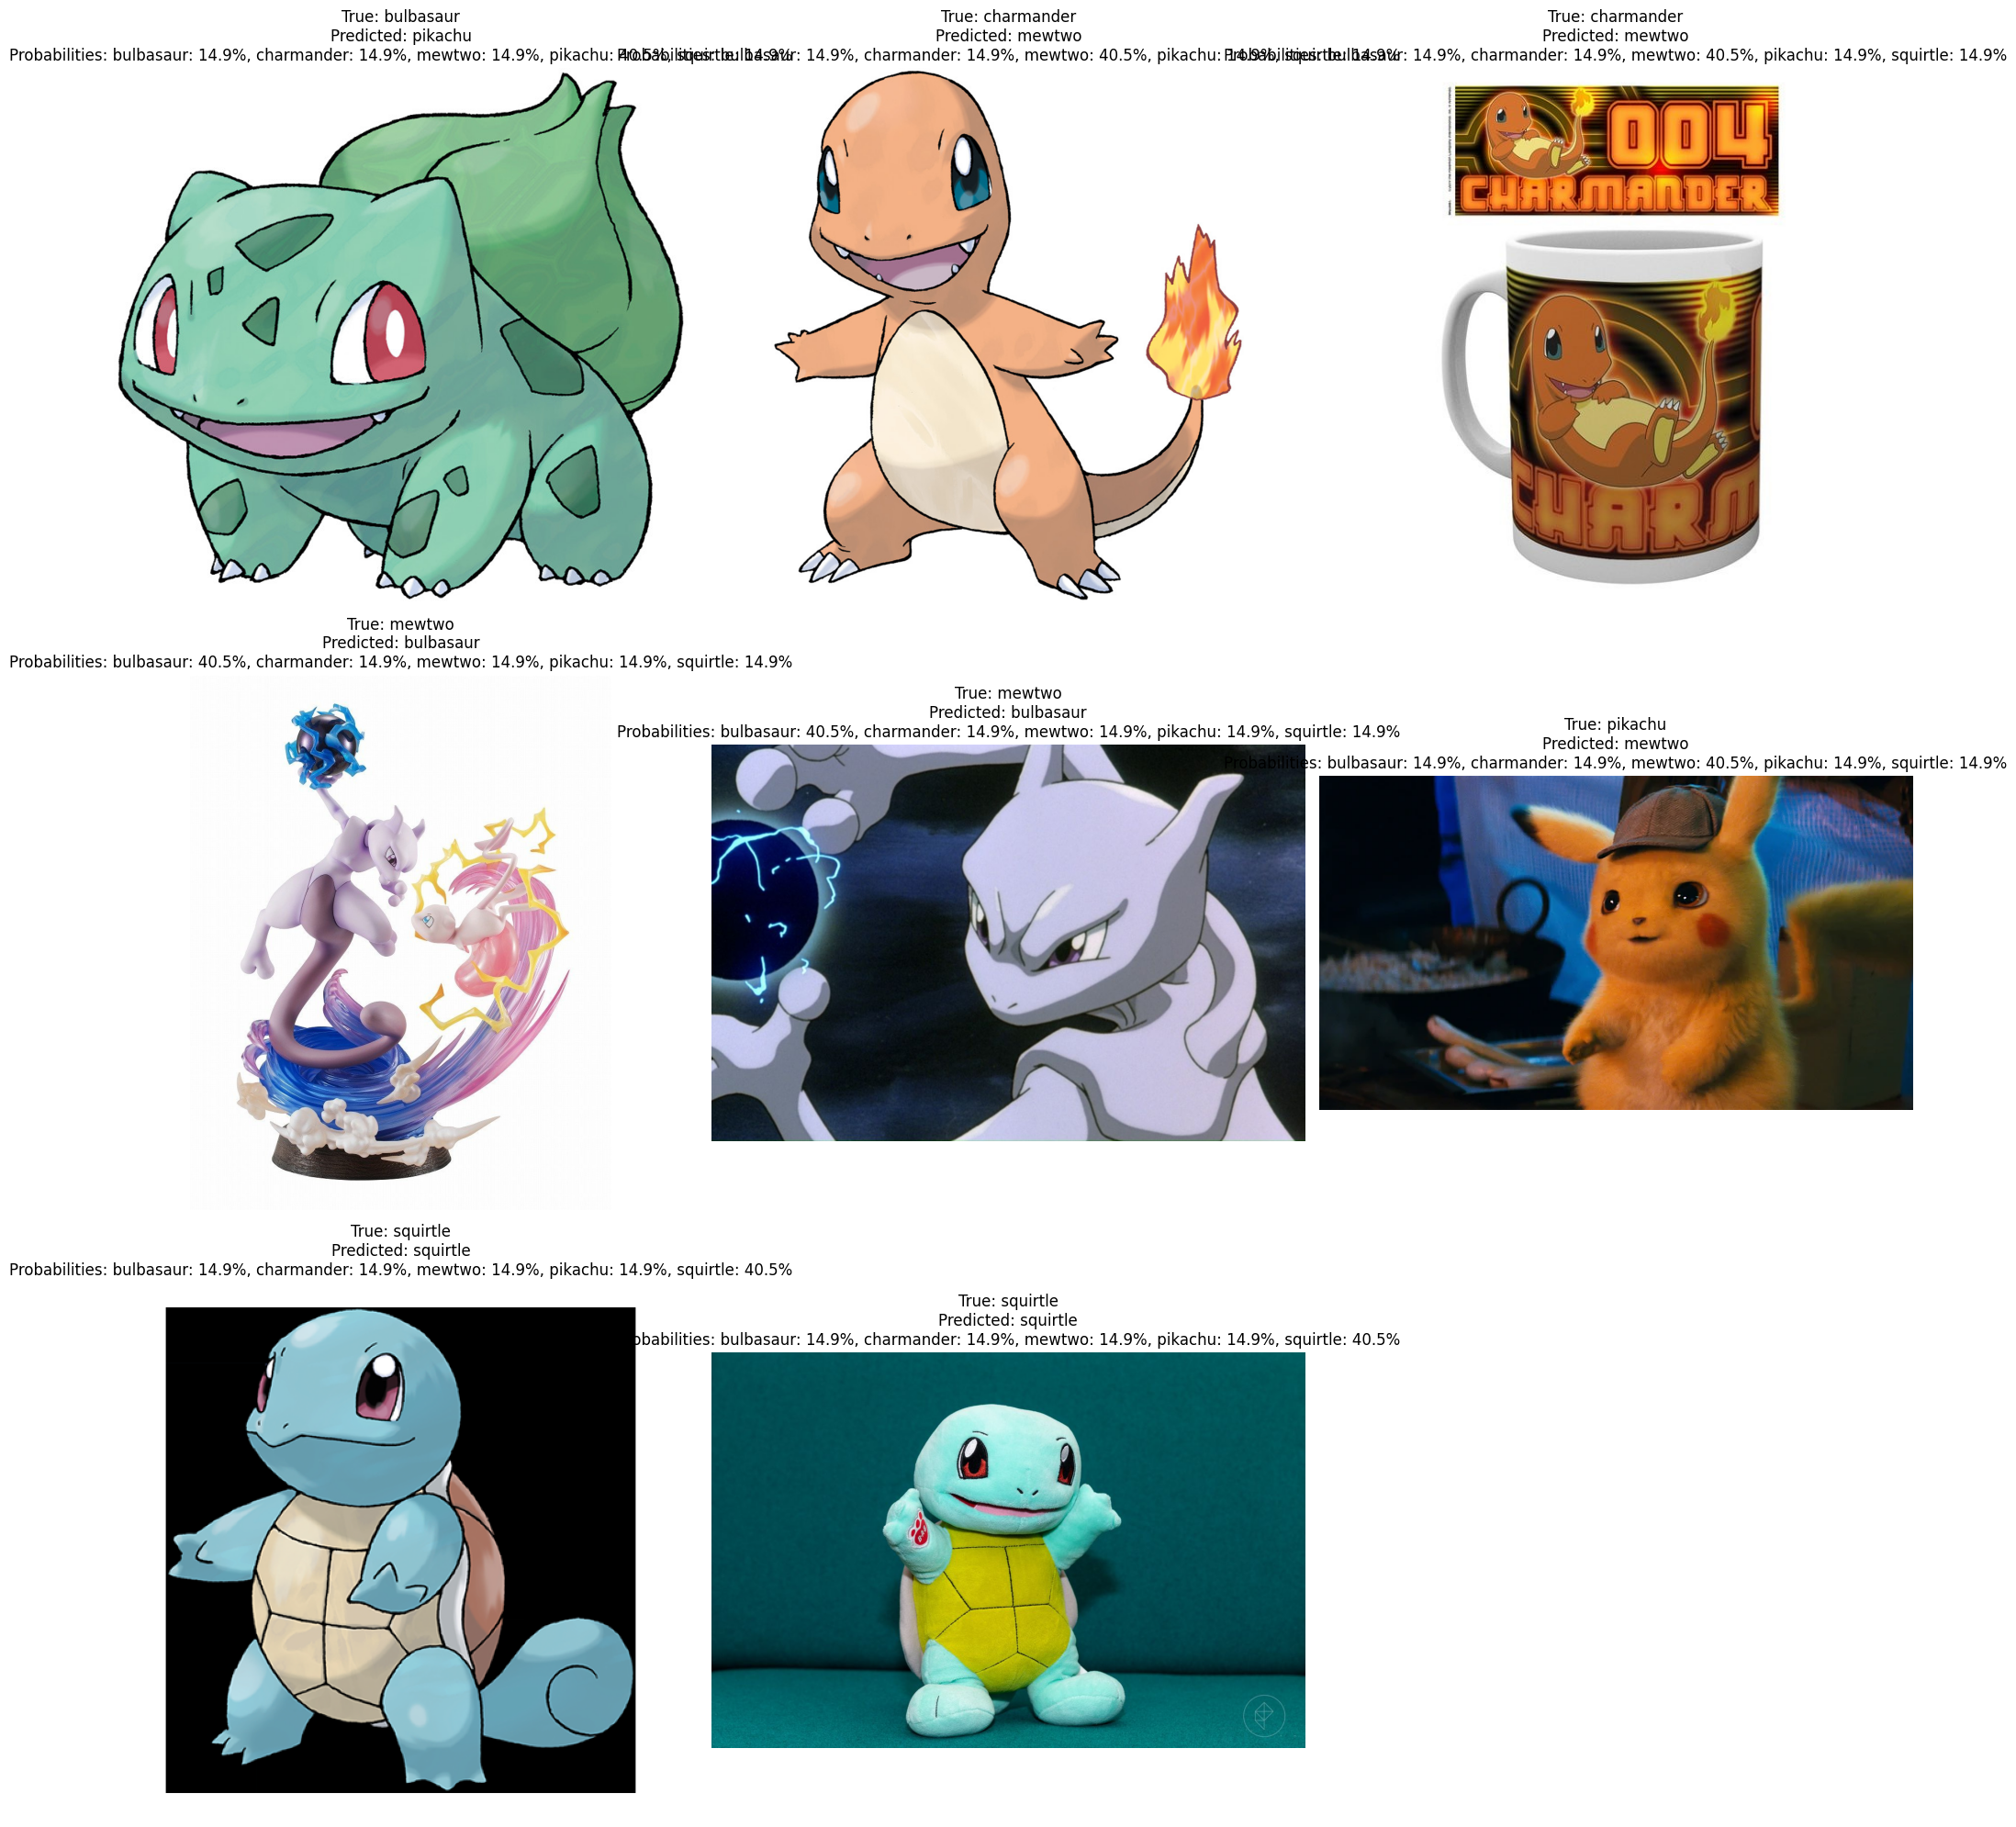

In [26]:
import os
import cv2 as cv
import torch
import numpy as np
import matplotlib.pyplot as plt


test_path = './Test'

# Cargar los pesos guardados
checkpoint_path = './working/best_model.pth'

# Cargar el modelo desde el checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])  # Cargar los pesos
model.eval()  # Poner el modelo en modo de evaluación
print("Pesos cargados desde el mejor modelo.")
model.to(device)

# Nombres de las clases (carpetas en el directorio Test)
class_names = sorted(os.listdir(test_path))

# Listas para almacenar resultados
true_labels = []
predicted_labels = []
images_list = []
probabilities_list = []

# Leer las imágenes y predecir
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(test_path, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)

        try:
            # Leer la imagen
            image = cv.imread(image_path)
            if image is None:
                print(f"No se pudo leer la imagen {image_path}")
                continue

            # Almacenar la imagen original para visualización
            images_list.append(image)

            # Preprocesar la imagen para el modelo
            image_resized = cv.resize(image, (96, 96))  # Redimensionar
            image_tensor = torch.tensor(image_resized.transpose((2, 0, 1)), dtype=torch.float32) / 255.0  # Normalizar
            image_tensor = image_tensor.unsqueeze(0).to(device)  # Añadir dimensión de lote

            # Hacer la predicción
            with torch.no_grad():
                preds = model(image_tensor)
                pred_class = preds.argmax(dim=1).item()
                probabilities = torch.softmax(preds, dim=1).squeeze().cpu().numpy()  # Calcular probabilidades

            # Guardar etiquetas y probabilidades
            true_labels.append(class_index)
            predicted_labels.append(pred_class)
            probabilities_list.append(probabilities)

        except Exception as e:
            print(f"Error procesando {image_path}: {e}")

# Mostrar resultados
rows, cols = 3, 3  # Configurar número de filas y columnas
fig = plt.figure(figsize=(20, 20))

for i in range(min(len(images_list), rows * cols)):
    image = images_list[i]
    true_class = class_names[true_labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    probabilities = probabilities_list[i]

    # Mostrar la imagen y las etiquetas
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(f"True: {true_class}\nPredicted: {predicted_class}\n"
              f"Probabilities: {', '.join([f'{class_names[j]}: {probabilities[j]*100:.1f}%' for j in range(len(class_names))])}")
    plt.axis('off')

plt.tight_layout()
plt.show()